In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [30]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(123)

In [31]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [32]:
BASEPATH = "../input/siim-isic-melanoma-classification"
df_train = pd.read_csv(os.path.join(BASEPATH, 'train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))

In [33]:
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [34]:
train_path = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_path = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

In [35]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224),batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224),batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224),batch_size=10, shuffle=False)

Found 2239 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [36]:
SEED = 123
batch_size = 10
img_height = 224
img_width =  224

In [37]:
classes=['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']

In [38]:

import pathlib
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

In [39]:
from PIL import Image
import os, sys

path = "../input/siim-isic-melanoma-classification/jpeg/train"
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((224,224), Image.ANTIALIAS)
            imResize.save(f + ' resized.jpg', 'JPEG', quality=90)

resize()

In [40]:
imgs, labels = next(train_batches)


In [41]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

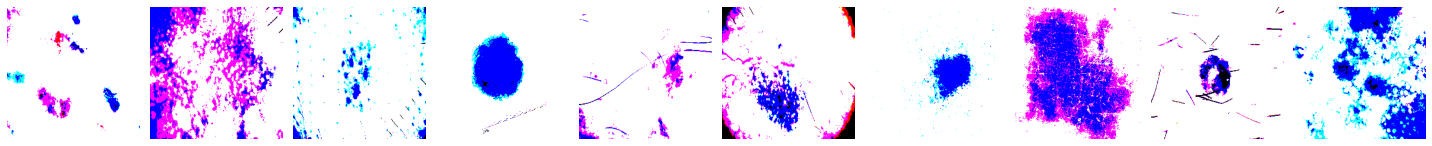

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [42]:
plotImages(imgs)
print(labels)

In [43]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units= 9, activation='sigmoid')
])

In [44]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1806345   
Total params: 1,825,737
Trainable params: 1,825,737
Non-trainable params: 0
____________________________________________

In [46]:
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
224/224 - 160s - loss: 1.4354 - accuracy: 0.3899 - val_loss: 0.2332 - val_accuracy: 0.6096
Epoch 2/10
224/224 - 159s - loss: 0.2013 - accuracy: 0.6811 - val_loss: 0.1343 - val_accuracy: 0.8490
Epoch 3/10
224/224 - 158s - loss: 0.1483 - accuracy: 0.8124 - val_loss: 0.1007 - val_accuracy: 0.9008
Epoch 4/10
224/224 - 159s - loss: 0.1210 - accuracy: 0.8647 - val_loss: 0.0870 - val_accuracy: 0.9080
Epoch 5/10
224/224 - 158s - loss: 0.1048 - accuracy: 0.8888 - val_loss: 0.0736 - val_accuracy: 0.9312
Epoch 6/10
224/224 - 159s - loss: 0.0925 - accuracy: 0.9067 - val_loss: 0.0819 - val_accuracy: 0.9290
Epoch 7/10
224/224 - 159s - loss: 0.0895 - accuracy: 0.9089 - val_loss: 0.0684 - val_accuracy: 0.9357
Epoch 8/10
224/224 - 159s - loss: 0.0804 - accuracy: 0.9089 - val_loss: 0.0606 - val_accuracy: 0.9348
Epoch 9/10
224/224 - 159s - loss: 0.0774 - accuracy: 0.9174 - val_loss: 0.0575 - val_accuracy: 0.9348
Epoch 10/10
224/224 - 159s - loss: 0.0698 - accuracy: 0.9111 - val_loss: 0.0494 - 

In [47]:
test_imgs, test_labels = next(test_batches)

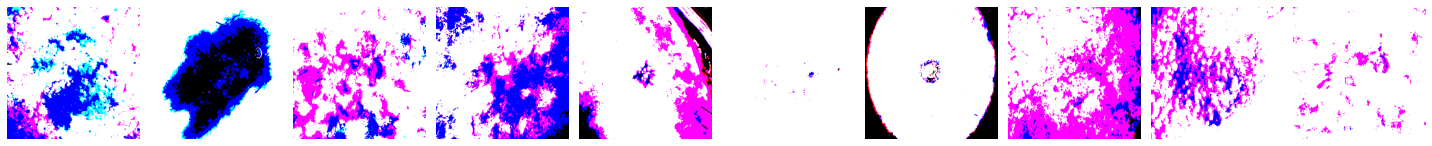

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [48]:
plotImages(test_imgs)
print(test_labels)

In [49]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [50]:
np.round(predictions)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

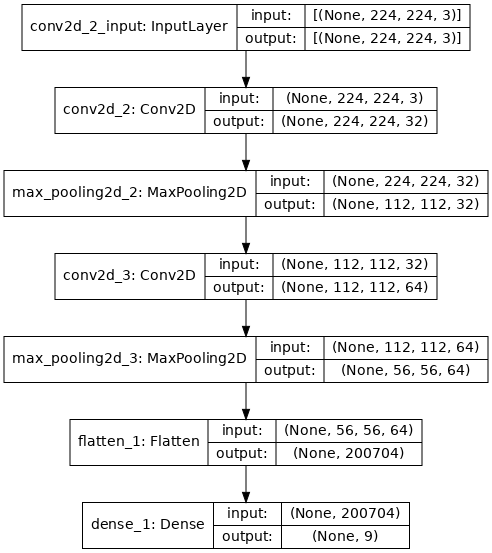

In [51]:
tf.keras.utils.plot_model(model = model , rankdir="TB", dpi=72, show_shapes=True)

In [52]:
model.evaluate(test_imgs, test_labels)

1/1 [==============================] - 0s 239ms/step - loss: 0.9433 - accuracy: 0.0000e+00


[0.9432829022407532, 0.0]

In [53]:
print('test data', test_imgs)
preds = np.round(model.predict(test_imgs),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[ -6.939003     1.2210007   22.32      ]
   [ -9.939003    -1.7789993   22.32      ]
   [-14.939003    -2.7789993   22.32      ]
   ...
   [ 12.060997     5.2210007   33.32      ]
   [ 12.060997     5.2210007   33.32      ]
   [  7.060997     6.2210007   35.32      ]]

  [[ -5.939003     2.2210007   23.32      ]
   [ -8.939003    -0.7789993   23.32      ]
   [-12.939003    -0.7789993   24.32      ]
   ...
   [ 10.060997     7.2210007   34.32      ]
   [  9.060997     4.2210007   34.32      ]
   [ 10.060997     6.2210007   33.32      ]]

  [[ -5.939003     2.2210007   23.32      ]
   [ -7.939003     0.22100067  24.32      ]
   [-10.939003    -0.7789993   24.32      ]
   ...
   [  8.060997     4.2210007   34.32      ]
   [ 10.060997     4.2210007   36.32      ]
   [ 12.060997     8.221001    35.32      ]]

  ...

  [[-21.939003   -15.778999    15.32      ]
   [-16.939003   -11.778999    18.32      ]
   [-15.939003   -13.778999    18.32      ]
   ...
   [  4.060997     1.2210

In [54]:
from sklearn import metrics
classes=['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=classes )
print(classification_metrics)

                            precision    recall  f1-score   support

pigmented benign keratosis       0.00      0.00      0.00        10
                  melanoma       0.00      0.00      0.00         0
           vascular lesion       0.00      0.00      0.00         0
         actinic keratosis       0.00      0.00      0.00         0
   squamous cell carcinoma       0.00      0.00      0.00         0
      basal cell carcinoma       0.00      0.00      0.00         0
      seborrheic keratosis       0.00      0.00      0.00         0
            dermatofibroma       0.00      0.00      0.00         0
                     nevus       0.00      0.00      0.00         0

                 micro avg       0.00      0.00      0.00        10
                 macro avg       0.00      0.00      0.00        10
              weighted avg       0.00      0.00      0.00        10
               samples avg       0.00      0.00      0.00        10



In [55]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'epochs' is not defined

In [ ]:
def plot_history(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_history(history)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels = ['actinic keratosis','basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
cm_plot_labels = ['melanoma']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
import sklearn.metrics as metrics

In [ ]:
from sklearn.metrics import classification_report
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224),batch_size=10, shuffle=False)

predictions = model.predict_generator(
    test_batches,
    steps = np.math.ceil(test_batches.samples / test_batches.batch_size),
    )
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_batches.classes
class_labels = list(test_batches.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
accuracy = metrics.accuracy_score(true_classes, predicted_classes) 

In [ ]:
print(report)